In [1]:
# import libraries
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import pandas as pd
from scipy import stats
import seaborn as sns
from datetime import datetime

# specify number of rows and columns to show
pd.set_option('display.max_rows', 25) 
pd.set_option('display.max_columns', 20)

# set default number format to 3 decimal places
pd.options.display.float_format = '{:40,.3f}'.format

# set ggplot style for plots
plt.style.use('ggplot') 

# Set seaborn style
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Import the cleaned dataset

fulldata1 = pd.read_csv('1EveryoneActive_CLEANED.csv')
fulldata2 = pd.read_csv('2EveryoneActive_CLEANED.csv')

# Combine the two imported sets
frames = [fulldata1, fulldata2]
fulldata = pd.concat(frames)

# Drop unused columns
columns = ['ActivityType', 'CitySaveActiveWestminster', 'FirstVisit']
fulldata.drop(columns, inplace=True, axis=1)

# Drop duplicate MemberIDs so we are only counting each member once

# First break off the '0' MembershipIDs since they are unique and we will keep them
fulldata_0 = fulldata.loc[fulldata['MembershipID'] == 0]

# Drop duplicates from the rest of the main dataset, keeping just the last instance of MembershipID
fulldata_IDdrop = fulldata.drop_duplicates(['MembershipID'], keep='last')

# Re-combine the two dataframes
frames = [fulldata_0, fulldata_IDdrop]
allSC = pd.concat(frames)

# Drop all unknown (XXXX) postcodes for spatial analysis work
SC_allpost = allSC.loc[allSC['Postcode'] != 'XXXX']

# SPLIT THE DATA BY SPORTSCENTRE
porch = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Porchester Hall']
qm = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Queen Mother SC']
marsh = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Marshall Street LC']
sey = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Seymour LC']
jub = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Jubilee SC']
lv = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Little Venice SC']
mob = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Moberly SC']
pad = SC_allpost.loc[SC_allpost['SportsCentre'] == 'Paddington Rec Ground']

In [3]:
# Generate counts for each Postcode
post_group = SC_allpost.groupby(['Postcode']).count().reset_index()

# Create new column of the count per Postcode
post_group['PostCount'] = post_group[['MembershipID']]
post_group = post_group[['Postcode','PostCount']]

# Truncate the Postcodes by removing the space in-between them
post_group['Postcode'] = post_group['Postcode'].str.replace(' ', '')

In [4]:
# Import the ACORN geodemographic categories with postcode
acorn = pd.read_csv('ACORN_codes.csv')

# Append the ACORN categories to the EveryoneActive counts using Postcode attribute
post_merge = pd.merge(post_group, acorn, on='Postcode', how='outer')

# Calculate the % of each Category, Category Group, and Category Type
geo_counts = post_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts['pct'] = (geo_counts['count']/geo_counts['count'].sum())*100

geo_counts_type = post_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type['pct'] = (geo_counts_type['count']/geo_counts_type['count'].sum())*100


geo_counts_group = post_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group['pct'] = (geo_counts_group['count']/geo_counts_group['count'].sum())*100




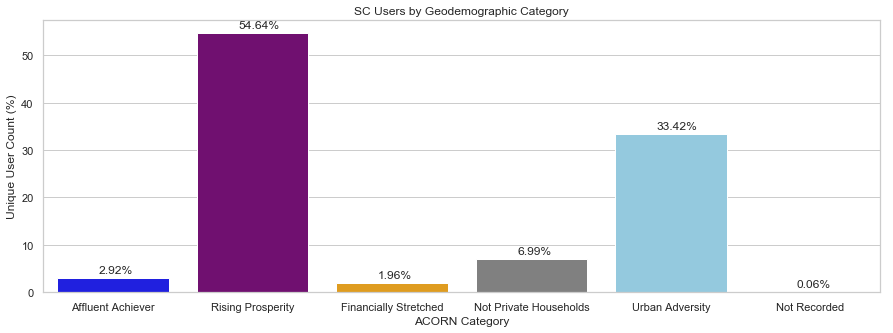

In [5]:
# Plot of Westminster users by ACORN category (%)
plt.figure(figsize=(15, 5))

colors = {'Affluent Achiever':'blue', 'Rising Prosperity':'purple', 'Financially Stretched':'orange', 'Not Private Households':'grey', 'Urban Adversity':'skyblue', 'Not Recorded':'grey'}

ax = sns.barplot(x="Category", y="pct", data=geo_counts, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts.loc[geo_counts['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts.loc[geo_counts['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts.loc[geo_counts['Category'] == 'Financially Stretched'].pct
c4 = geo_counts.loc[geo_counts['Category'] == 'Not Private Households'].pct
c5 = geo_counts.loc[geo_counts['Category'] == 'Urban Adversity'].pct
c6 = geo_counts.loc[geo_counts['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('SC Users by Geodemographic Category')


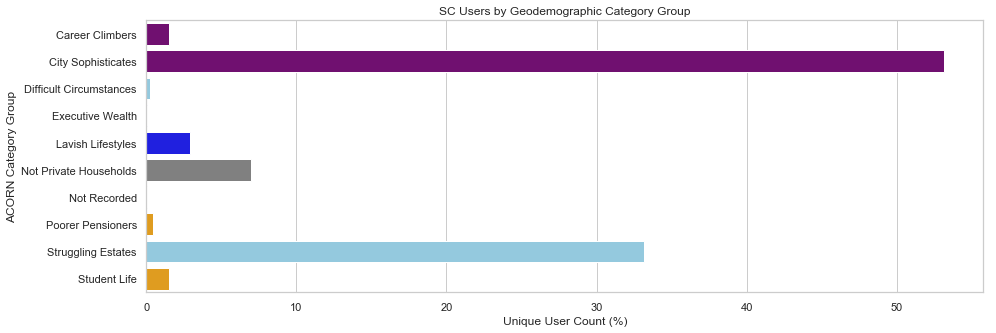

In [6]:
# Plot of Westminster users by ACORN Category Group (%)

colors = {'Lavish Lifestyles':'blue', 'Executive Wealth':'blue', 'Mature Money':'blue', 'City Sophisticates':'Purple', 'Career Climbers':'Purple', 'Student Life':'orange', 'Poorer Pensioners':'orange', 'Struggling Estates':'skyblue', 'Difficult Circumstances': 'skyblue','Not Recorded':'grey', 'Not Private Households':'grey'}

plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('SC Users by Geodemographic Category Group')

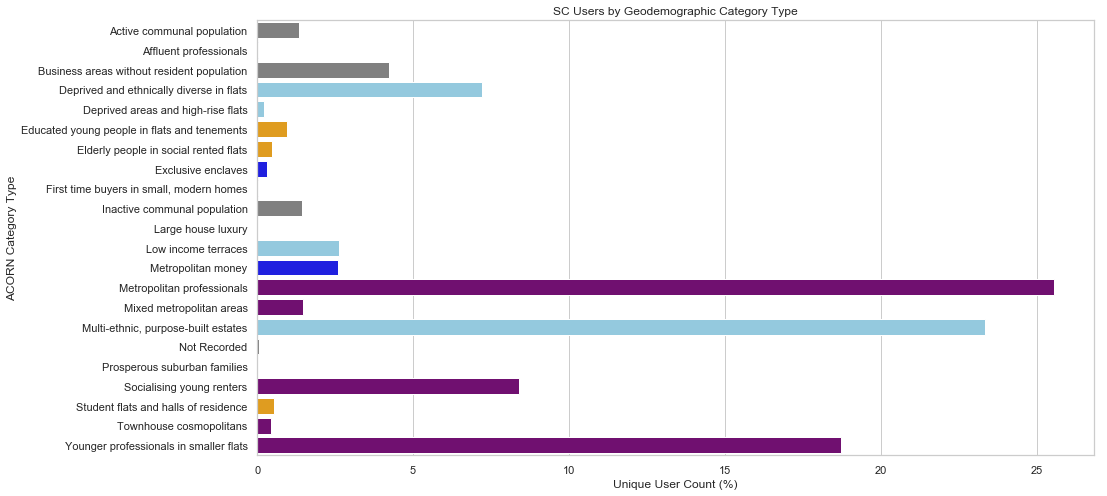

In [7]:
# Plot of Westminster users by ACORN Category Type

colors = {'Metropolitan money':'blue', 'Metropolitan professionals':'purple', 'Exclusive enclaves':'blue', 'Student flats and halls of residence':'orange', 'Younger professionals in smaller flats':'Purple', 'Business areas without resident population':'grey', 'Multi-ethnic, purpose-built estates':'skyblue', 'Mixed metropolitan areas':'purple', 
          'Active communal population': 'grey','Socialising young renters':'purple', 'Educated young people in flats and tenements':'orange', 'Inactive communal population': 'grey',
         'Elderly people in social rented flats': 'orange','Deprived and ethnically diverse in flats': 'skyblue','Townhouse cosmopolitans': 'purple','Deprived areas and high-rise flats': 'skyblue','Affluent professionals': 'blue',
         'First time buyers in small, modern homes': 'purple','Not Recorded': 'grey','Low income terraces': 'skyblue', 'Prosperous suburban families': 'blue','Large house luxury': 'blue'}


plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('SC Users by Geodemographic Category Type')

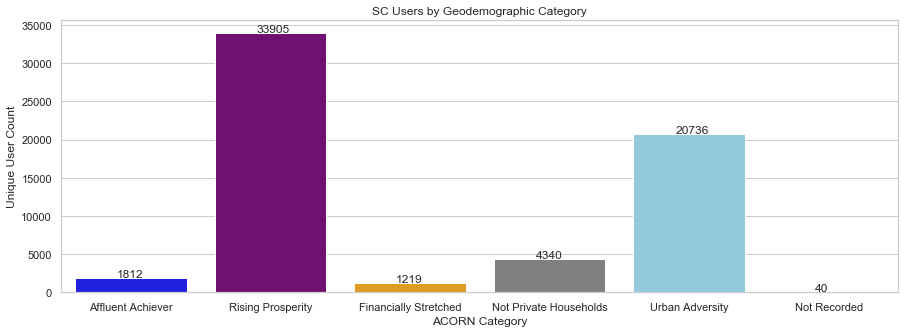

In [8]:
# Plot of Westminster users by ACORN category. SAME AS ABOVE, BUT ACTUAL COUNTS (NOT %)

plt.figure(figsize=(15, 5))

colors = {'Affluent Achiever':'blue', 'Rising Prosperity':'purple', 'Financially Stretched':'orange', 'Not Private Households':'grey', 'Urban Adversity':'skyblue', 'Not Recorded':'grey'}

ax = sns.barplot(x="Category", y="PostCount", data=post_merge, estimator = sum, ci=None, palette=colors)

c1 = post_merge.loc[post_merge['Category'] == 'Affluent Achiever'].PostCount.sum()
c2 = post_merge.loc[post_merge['Category'] == 'Rising Prosperity'].PostCount.sum()
c3 = post_merge.loc[post_merge['Category'] == 'Financially Stretched'].PostCount.sum()
c4 = post_merge.loc[post_merge['Category'] == 'Not Private Households'].PostCount.sum()
c5 = post_merge.loc[post_merge['Category'] == 'Urban Adversity'].PostCount.sum()
c6 = post_merge.loc[post_merge['Category'] == 'Not Recorded'].PostCount.sum()


plt.text(-0.1,c1+100, str(int(c1)), fontsize = 12)
plt.text(0.9,c2+100, str(int(c2)), fontsize = 12)
plt.text(1.9,c3+100, str(int(c3)), fontsize = 12)
plt.text(2.9,c4+100, str(int(c4)), fontsize = 12)
plt.text(3.9,c5+100, str(int(c5)), fontsize = 12)
plt.text(4.9,c6+100, str(int(c6)), fontsize = 12)

ax.set(ylabel="Unique User Count")
ax.set(xlabel="ACORN Category")
ax = plt.title('SC Users by Geodemographic Category')

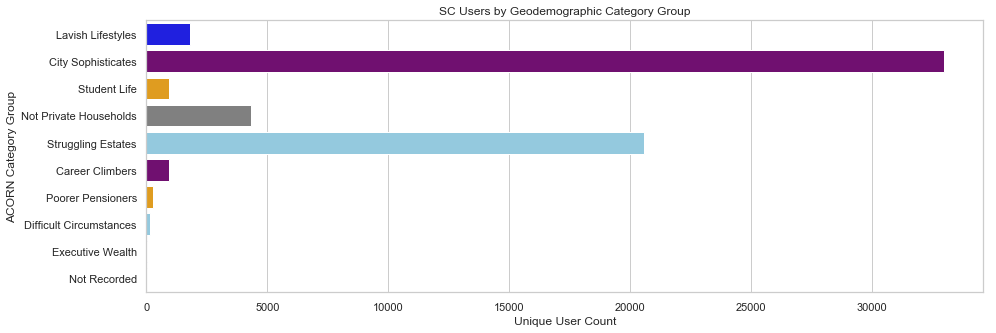

In [9]:
# Plot of Westminster users by ACORN Category Group. SAME AS ABOVE, BUT ACTUAL COUNTS (NOT %)

colors = {'Lavish Lifestyles':'blue', 'Executive Wealth':'blue', 'Mature Money':'blue', 'City Sophisticates':'Purple', 'Career Climbers':'Purple', 'Student Life':'orange', 'Poorer Pensioners':'orange', 'Struggling Estates':'skyblue', 'Difficult Circumstances': 'skyblue','Not Recorded':'grey', 'Not Private Households':'grey'}


plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="PostCount", data=post_merge, estimator = sum, ci=None, palette=colors)

ax.set(xlabel="Unique User Count")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('SC Users by Geodemographic Category Group')

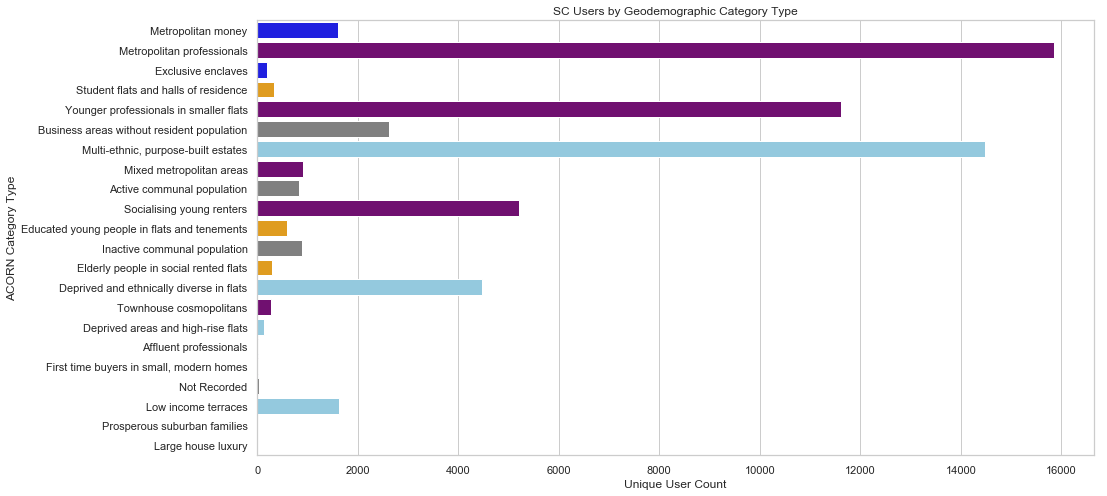

In [10]:
# Plot of Westminster users by ACORN Category Type. SAME AS ABOVE, BUT ACTUAL COUNTS (NOT %)

colors = {'Metropolitan money':'blue', 'Metropolitan professionals':'purple', 'Exclusive enclaves':'blue', 'Student flats and halls of residence':'orange', 'Younger professionals in smaller flats':'Purple', 'Business areas without resident population':'grey', 'Multi-ethnic, purpose-built estates':'skyblue', 'Mixed metropolitan areas':'purple', 
          'Active communal population': 'grey','Socialising young renters':'purple', 'Educated young people in flats and tenements':'orange', 'Inactive communal population': 'grey',
         'Elderly people in social rented flats': 'orange','Deprived and ethnically diverse in flats': 'skyblue','Townhouse cosmopolitans': 'purple','Deprived areas and high-rise flats': 'skyblue','Affluent professionals': 'blue',
         'First time buyers in small, modern homes': 'purple','Not Recorded': 'grey','Low income terraces': 'skyblue', 'Prosperous suburban families': 'blue','Large house luxury': 'blue'}



plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="PostCount", data=post_merge, estimator = sum, ci=None, palette = colors)

ax.set(xlabel="Unique User Count")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('SC Users by Geodemographic Category Type')

In [11]:
# GENERATE GRAPHS BY SPORTSCENTRE

# Generate counts for each Postcode
porch_group = porch.groupby(['Postcode']).count().reset_index()
qm_group = qm.groupby(['Postcode']).count().reset_index()
marsh_group = marsh.groupby(['Postcode']).count().reset_index()
sey_group = sey.groupby(['Postcode']).count().reset_index()
jub_group = jub.groupby(['Postcode']).count().reset_index()
lv_group = lv.groupby(['Postcode']).count().reset_index()
mob_group = mob.groupby(['Postcode']).count().reset_index()
pad_group = pad.groupby(['Postcode']).count().reset_index()

# Create new column of the count per Postcode
porch_group['PostCount'] = porch_group[['MembershipID']]
porch_group = porch_group[['Postcode','PostCount']]

qm_group['PostCount'] = qm_group[['MembershipID']]
qm_group = qm_group[['Postcode','PostCount']]

marsh_group['PostCount'] = marsh_group[['MembershipID']]
marsh_group = marsh_group[['Postcode','PostCount']]

sey_group['PostCount'] = sey_group[['MembershipID']]
sey_group = sey_group[['Postcode','PostCount']]

jub_group['PostCount'] = jub_group[['MembershipID']]
jub_group = jub_group[['Postcode','PostCount']]

lv_group['PostCount'] = lv_group[['MembershipID']]
lv_group = lv_group[['Postcode','PostCount']]

mob_group['PostCount'] = mob_group[['MembershipID']]
mob_group = mob_group[['Postcode','PostCount']]

pad_group['PostCount'] = pad_group[['MembershipID']]
pad_group = pad_group[['Postcode','PostCount']]


# Truncate the Postcodes by removing the space in-between them
porch_group['Postcode'] = porch_group['Postcode'].str.replace(' ', '')
qm_group['Postcode'] = qm_group['Postcode'].str.replace(' ', '')
marsh_group['Postcode'] = marsh_group['Postcode'].str.replace(' ', '')
sey_group['Postcode'] = sey_group['Postcode'].str.replace(' ', '')
jub_group['Postcode'] = jub_group['Postcode'].str.replace(' ', '')
lv_group['Postcode'] = lv_group['Postcode'].str.replace(' ', '')
mob_group['Postcode'] = mob_group['Postcode'].str.replace(' ', '')
pad_group['Postcode'] = pad_group['Postcode'].str.replace(' ', '')

# Append the ACORN categories to the EveryoneActive counts using Postcode attribute
porch_merge = pd.merge(porch_group, acorn, on='Postcode', how='outer')
qm_merge = pd.merge(qm_group, acorn, on='Postcode', how='outer')
marsh_merge = pd.merge(marsh_group, acorn, on='Postcode', how='outer')
sey_merge = pd.merge(sey_group, acorn, on='Postcode', how='outer')
jub_merge = pd.merge(jub_group, acorn, on='Postcode', how='outer')
lv_merge = pd.merge(lv_group, acorn, on='Postcode', how='outer')
mob_merge = pd.merge(mob_group, acorn, on='Postcode', how='outer')
pad_merge = pd.merge(pad_group, acorn, on='Postcode', how='outer')

# Calculate the % of each Category, Category Group, and Category Type
geo_counts_porch = porch_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_porch['pct'] = (geo_counts_porch['count']/geo_counts_porch['count'].sum())*100

geo_counts_qm = qm_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_qm['pct'] = (geo_counts_qm['count']/geo_counts_qm['count'].sum())*100

geo_counts_marsh = marsh_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_marsh['pct'] = (geo_counts_marsh['count']/geo_counts_marsh['count'].sum())*100

geo_counts_sey = sey_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_sey['pct'] = (geo_counts_sey['count']/geo_counts_sey['count'].sum())*100

geo_counts_jub = jub_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_jub['pct'] = (geo_counts_jub['count']/geo_counts_jub['count'].sum())*100

geo_counts_lv = lv_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_lv['pct'] = (geo_counts_lv['count']/geo_counts_lv['count'].sum())*100

geo_counts_mob = mob_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_mob['pct'] = (geo_counts_mob['count']/geo_counts_mob['count'].sum())*100

geo_counts_pad = pad_merge.groupby(['Category']).PostCount.sum().rename('count').reset_index()
geo_counts_pad['pct'] = (geo_counts_pad['count']/geo_counts_pad['count'].sum())*100


# Category Type
geo_counts_type_porch = porch_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_porch['pct'] = (geo_counts_type_porch['count']/geo_counts_type_porch['count'].sum())*100

geo_counts_type_qm = qm_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_qm['pct'] = (geo_counts_type_qm['count']/geo_counts_type_qm['count'].sum())*100

geo_counts_type_marsh = marsh_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_marsh['pct'] = (geo_counts_type_marsh['count']/geo_counts_type_marsh['count'].sum())*100

geo_counts_type_sey = sey_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_sey['pct'] = (geo_counts_type_sey['count']/geo_counts_type_sey['count'].sum())*100

geo_counts_type_jub = jub_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_jub['pct'] = (geo_counts_type_jub['count']/geo_counts_type_jub['count'].sum())*100

geo_counts_type_lv = lv_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_lv['pct'] = (geo_counts_type_lv['count']/geo_counts_type_lv['count'].sum())*100

geo_counts_type_mob = mob_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_mob['pct'] = (geo_counts_type_mob['count']/geo_counts_type_mob['count'].sum())*100

geo_counts_type_pad = pad_merge.groupby(['CategoryType']).PostCount.sum().rename('count').reset_index()
geo_counts_type_pad['pct'] = (geo_counts_type_pad['count']/geo_counts_type_pad['count'].sum())*100

# Category Group
geo_counts_group_porch = porch_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_porch['pct'] = (geo_counts_group_porch['count']/geo_counts_group_porch['count'].sum())*100

geo_counts_group_qm = qm_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_qm['pct'] = (geo_counts_group_qm['count']/geo_counts_group_qm['count'].sum())*100

geo_counts_group_marsh = marsh_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_marsh['pct'] = (geo_counts_group_marsh['count']/geo_counts_group_marsh['count'].sum())*100

geo_counts_group_sey = sey_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_sey['pct'] = (geo_counts_group_sey['count']/geo_counts_group_sey['count'].sum())*100

geo_counts_group_jub = jub_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_jub['pct'] = (geo_counts_group_jub['count']/geo_counts_group_jub['count'].sum())*100

geo_counts_group_lv = lv_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_lv['pct'] = (geo_counts_group_lv['count']/geo_counts_group_lv['count'].sum())*100

geo_counts_group_mob = mob_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_mob['pct'] = (geo_counts_group_mob['count']/geo_counts_group_mob['count'].sum())*100

geo_counts_group_pad = pad_merge.groupby(['CategoryGroup']).PostCount.sum().rename('count').reset_index()
geo_counts_group_pad['pct'] = (geo_counts_group_pad['count']/geo_counts_group_pad['count'].sum())*100



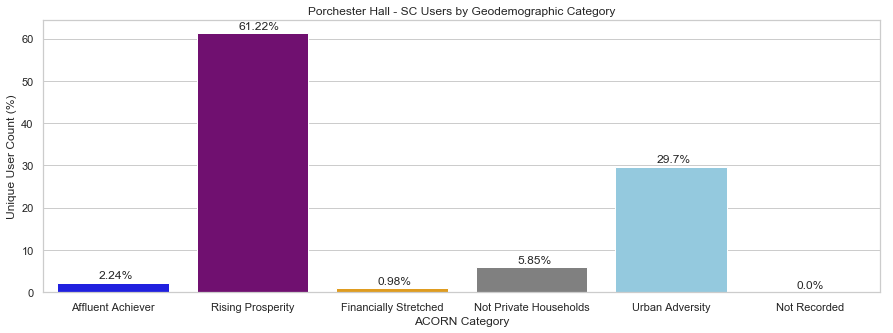

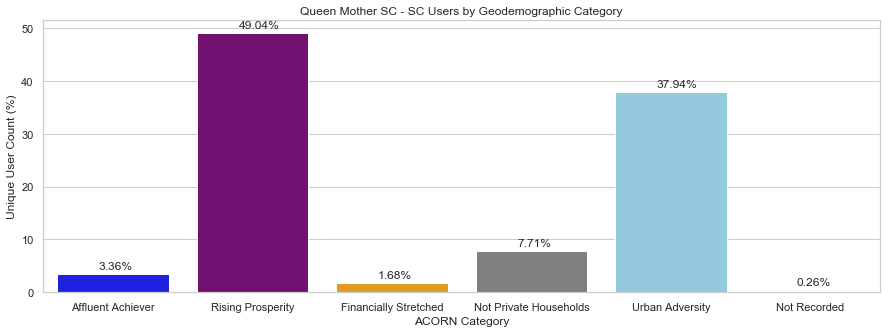

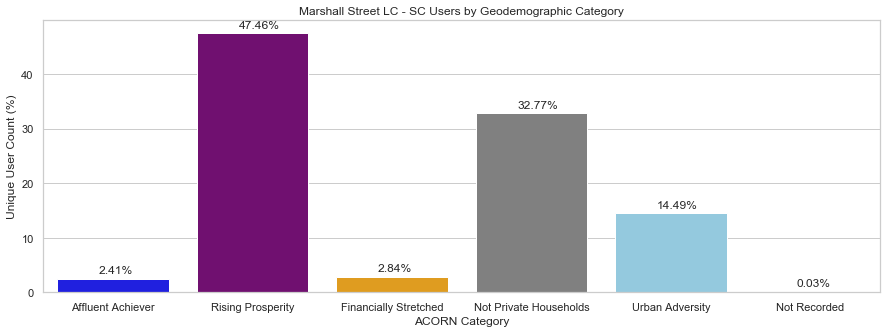

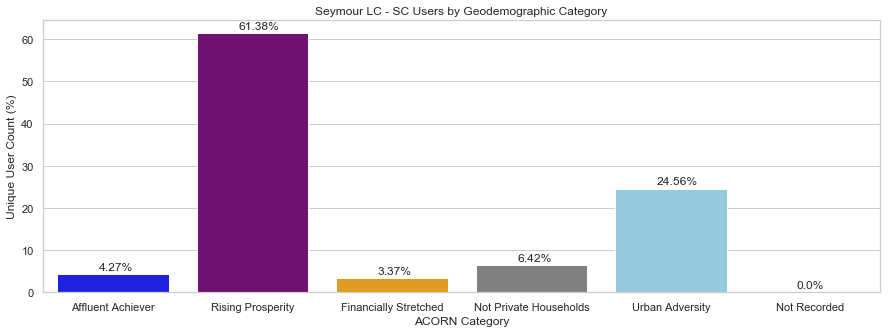

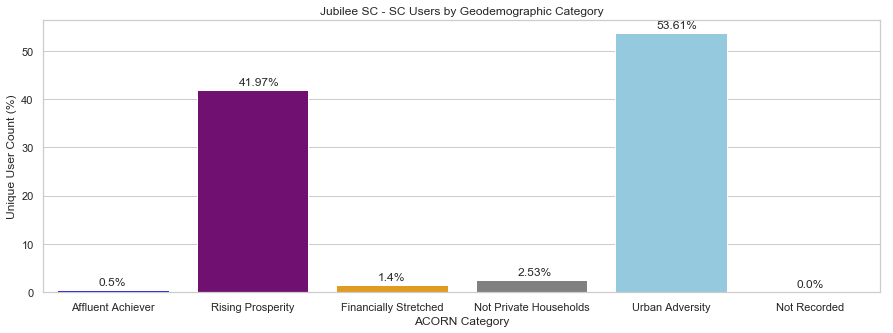

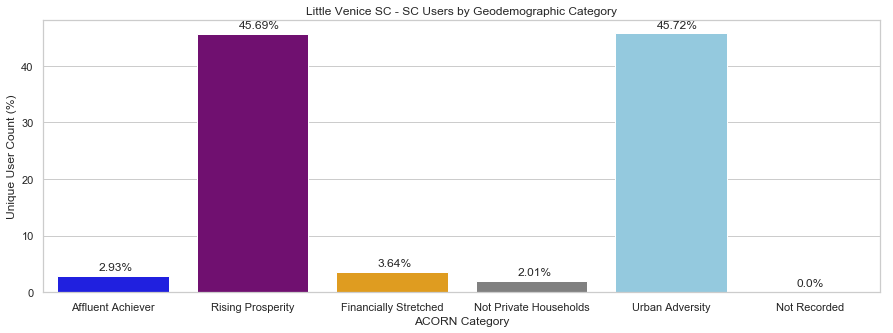

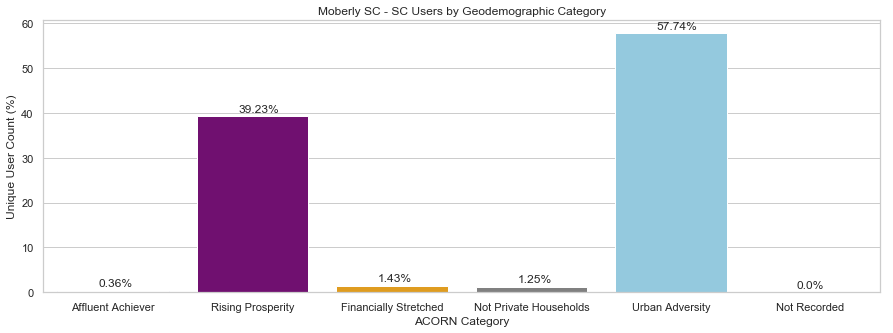

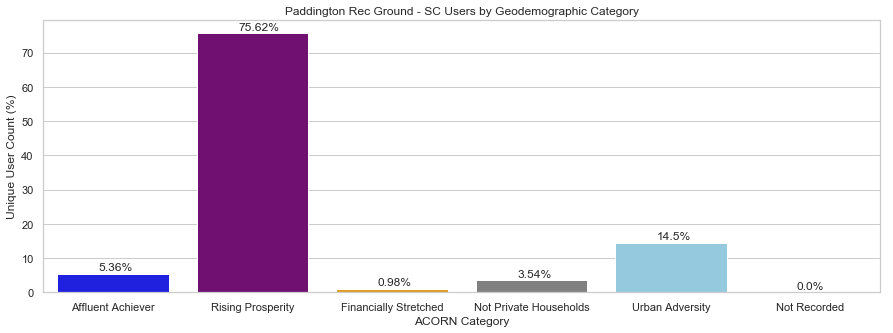

In [12]:
# Plot of users by ACORN category, by SportsCentre (%)
plt.figure(figsize=(15, 5))

colors = {'Affluent Achiever':'blue', 'Rising Prosperity':'purple', 'Financially Stretched':'orange', 'Not Private Households':'grey', 'Urban Adversity':'skyblue', 'Not Recorded':'grey'}

ax = sns.barplot(x="Category", y="pct", data=geo_counts_porch, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_porch.loc[geo_counts_porch['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_porch.loc[geo_counts_porch['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_porch.loc[geo_counts_porch['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_porch.loc[geo_counts_porch['Category'] == 'Not Private Households'].pct
c5 = geo_counts_porch.loc[geo_counts_porch['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_porch.loc[geo_counts_porch['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Porchester Hall - SC Users by Geodemographic Category')
plt.show()


# Queen Mother
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_qm, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_qm.loc[geo_counts_qm['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_qm.loc[geo_counts_qm['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_qm.loc[geo_counts_qm['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_qm.loc[geo_counts_qm['Category'] == 'Not Private Households'].pct
c5 = geo_counts_qm.loc[geo_counts_qm['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_qm.loc[geo_counts_qm['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Queen Mother SC - SC Users by Geodemographic Category')
plt.show()

# Marshall Street LC
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_marsh, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_marsh.loc[geo_counts_marsh['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_marsh.loc[geo_counts_marsh['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_marsh.loc[geo_counts_marsh['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_marsh.loc[geo_counts_marsh['Category'] == 'Not Private Households'].pct
c5 = geo_counts_marsh.loc[geo_counts_marsh['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_marsh.loc[geo_counts_marsh['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Marshall Street LC - SC Users by Geodemographic Category')
plt.show()

# Seymour LC
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_sey, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_sey.loc[geo_counts_sey['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_sey.loc[geo_counts_sey['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_sey.loc[geo_counts_sey['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_sey.loc[geo_counts_sey['Category'] == 'Not Private Households'].pct
c5 = geo_counts_sey.loc[geo_counts_sey['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_sey.loc[geo_counts_sey['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Seymour LC - SC Users by Geodemographic Category')
plt.show()

# Jubilee SC
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_jub, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_jub.loc[geo_counts_jub['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_jub.loc[geo_counts_jub['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_jub.loc[geo_counts_jub['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_jub.loc[geo_counts_jub['Category'] == 'Not Private Households'].pct
c5 = geo_counts_jub.loc[geo_counts_jub['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_jub.loc[geo_counts_jub['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Jubilee SC - SC Users by Geodemographic Category')
plt.show()

# Little Venice SC
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_lv, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_lv.loc[geo_counts_lv['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_lv.loc[geo_counts_lv['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_lv.loc[geo_counts_lv['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_lv.loc[geo_counts_lv['Category'] == 'Not Private Households'].pct
c5 = geo_counts_lv.loc[geo_counts_lv['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_lv.loc[geo_counts_lv['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Little Venice SC - SC Users by Geodemographic Category')
plt.show()


# Moberly SC
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_mob, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_mob.loc[geo_counts_mob['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_mob.loc[geo_counts_mob['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_mob.loc[geo_counts_mob['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_mob.loc[geo_counts_mob['Category'] == 'Not Private Households'].pct
c5 = geo_counts_mob.loc[geo_counts_mob['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_mob.loc[geo_counts_mob['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Moberly SC - SC Users by Geodemographic Category')
plt.show()

# Paddington Rec Ground
plt.figure(figsize=(15, 5))

ax = sns.barplot(x="Category", y="pct", data=geo_counts_pad, ci=None, palette=colors, order = ['Affluent Achiever','Rising Prosperity','Financially Stretched','Not Private Households','Urban Adversity','Not Recorded'])

c1 = geo_counts_pad.loc[geo_counts_pad['Category'] == 'Affluent Achiever'].pct
c2 = geo_counts_pad.loc[geo_counts_pad['Category'] == 'Rising Prosperity'].pct
c3 = geo_counts_pad.loc[geo_counts_pad['Category'] == 'Financially Stretched'].pct
c4 = geo_counts_pad.loc[geo_counts_pad['Category'] == 'Not Private Households'].pct
c5 = geo_counts_pad.loc[geo_counts_pad['Category'] == 'Urban Adversity'].pct
c6 = geo_counts_pad.loc[geo_counts_pad['Category'] == 'Not Recorded'].pct

plt.text(-0.1,c1+1, str(float(c1.round(2))) + '%', fontsize = 12)
plt.text(0.9,c2+1, str(float(c2.round(2)))+ '%', fontsize = 12)
plt.text(1.9,c3+1, str(float(c3.round(2)))+ '%', fontsize = 12)
plt.text(2.9,c4+1, str(float(c4.round(2)))+ '%', fontsize = 12)
plt.text(3.9,c5+1, str(float(c5.round(2)))+ '%', fontsize = 12)
plt.text(4.9,c6+1, str(float(c6.round(2)))+ '%', fontsize = 12)

ax.set(ylabel="Unique User Count (%)")
ax.set(xlabel="ACORN Category")
ax = plt.title('Paddington Rec Ground - SC Users by Geodemographic Category')
plt.show()

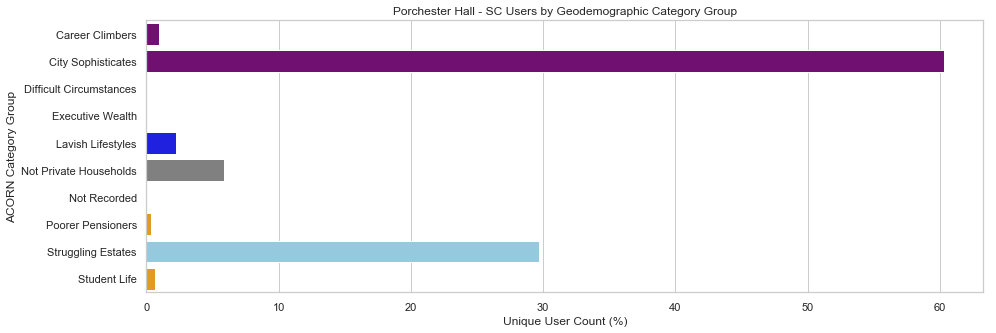

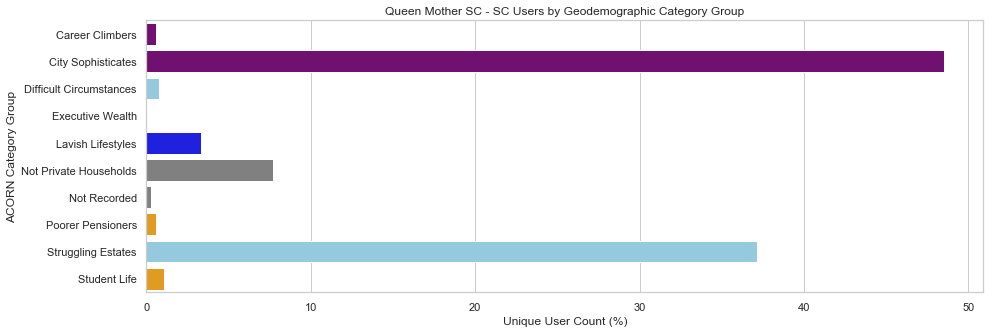

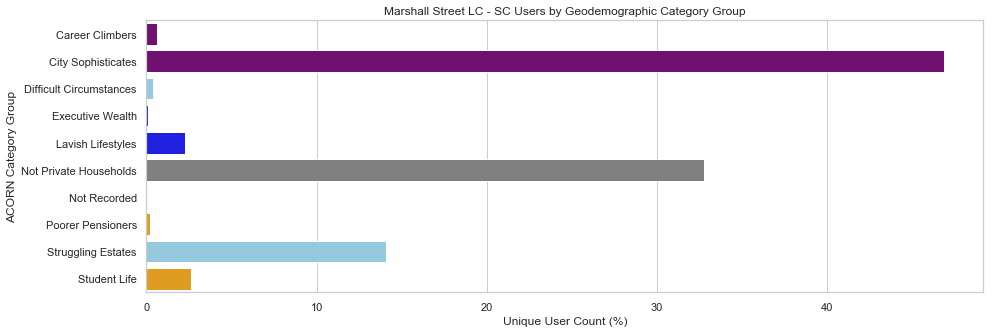

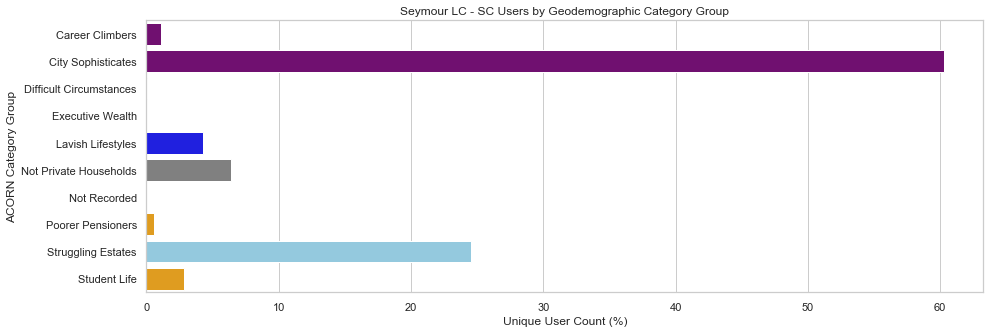

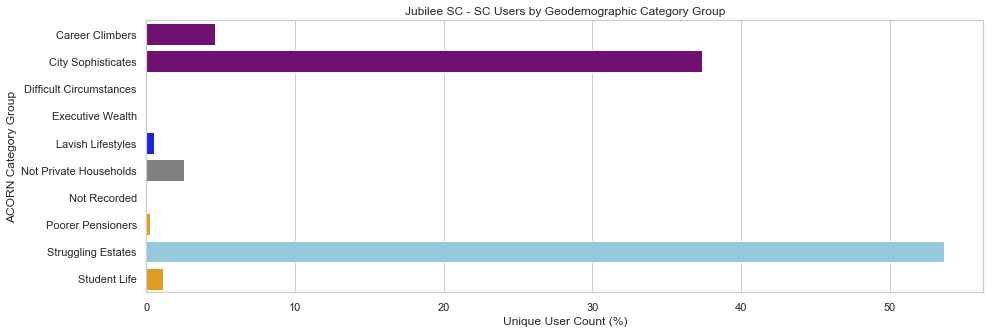

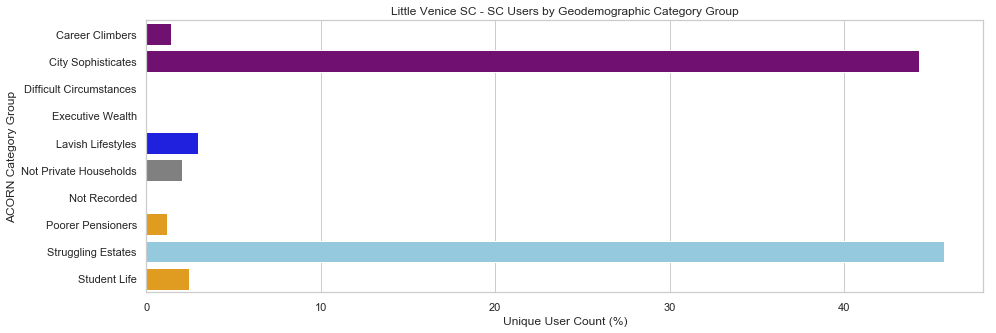

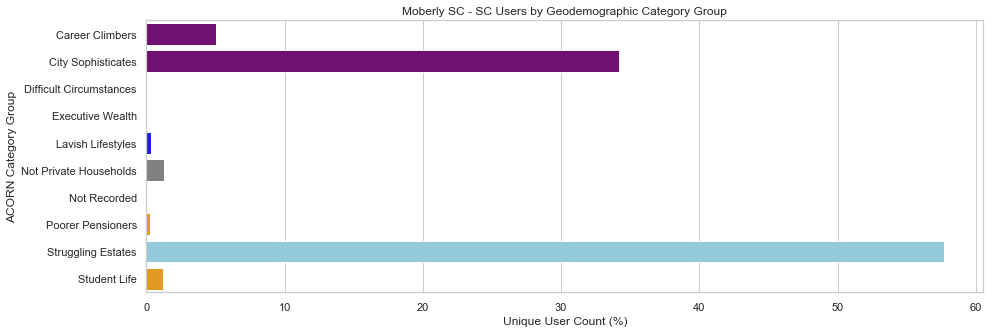

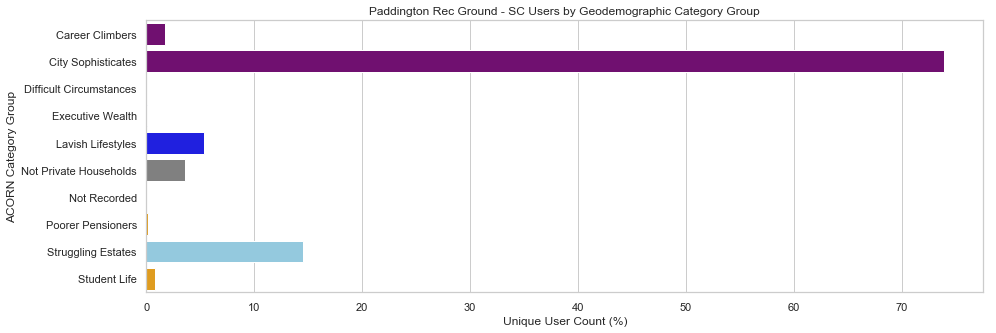

In [13]:
#  Plot of users by ACORN category group, by SportsCentre (%)

colors = {'Lavish Lifestyles':'blue', 'Executive Wealth':'blue', 'Mature Money':'blue', 'City Sophisticates':'Purple', 'Career Climbers':'Purple', 'Student Life':'orange', 'Poorer Pensioners':'orange', 'Struggling Estates':'skyblue', 'Difficult Circumstances': 'skyblue','Not Recorded':'grey', 'Not Private Households':'grey'}

# Porchester Hall
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_porch, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Porchester Hall - SC Users by Geodemographic Category Group')
plt.show()

# Queen Mother SC
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_qm, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Queen Mother SC - SC Users by Geodemographic Category Group')
plt.show()


# Marshall Street LC
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_marsh, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Marshall Street LC - SC Users by Geodemographic Category Group')
plt.show()

# Seymour LC
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_sey, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Seymour LC - SC Users by Geodemographic Category Group')
plt.show()


# Jubilee SC
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_jub, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Jubilee SC - SC Users by Geodemographic Category Group')
plt.show()

# Little Venice SC
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_lv, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Little Venice SC - SC Users by Geodemographic Category Group')
plt.show()

# Moberly SC
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_mob, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Moberly SC - SC Users by Geodemographic Category Group')
plt.show()


# Paddington Rec Ground
plt.figure(figsize=(15, 5))
ax = sns.barplot(y="CategoryGroup", x="pct", data=geo_counts_group_pad, ci=None, palette=colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Group")
ax = plt.title('Paddington Rec Ground - SC Users by Geodemographic Category Group')
plt.show()

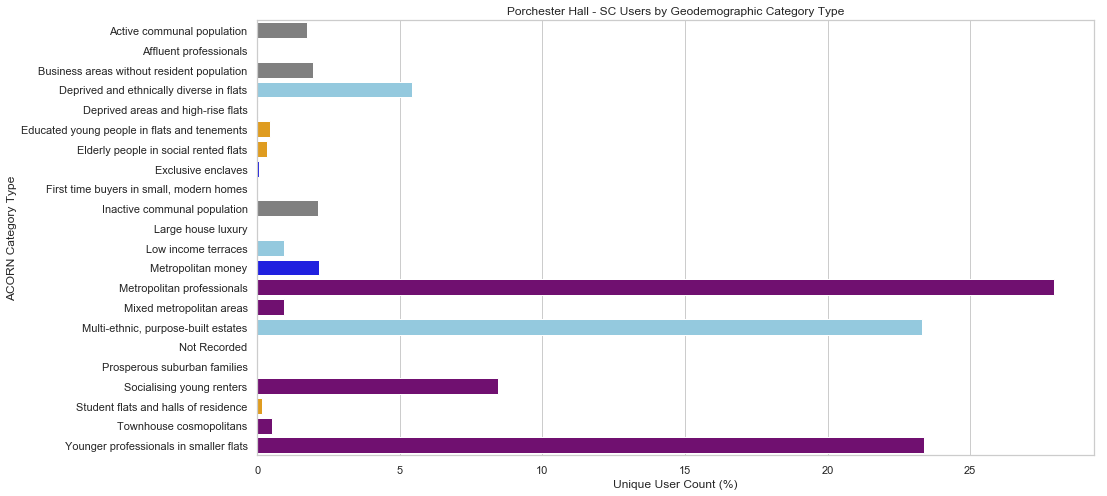

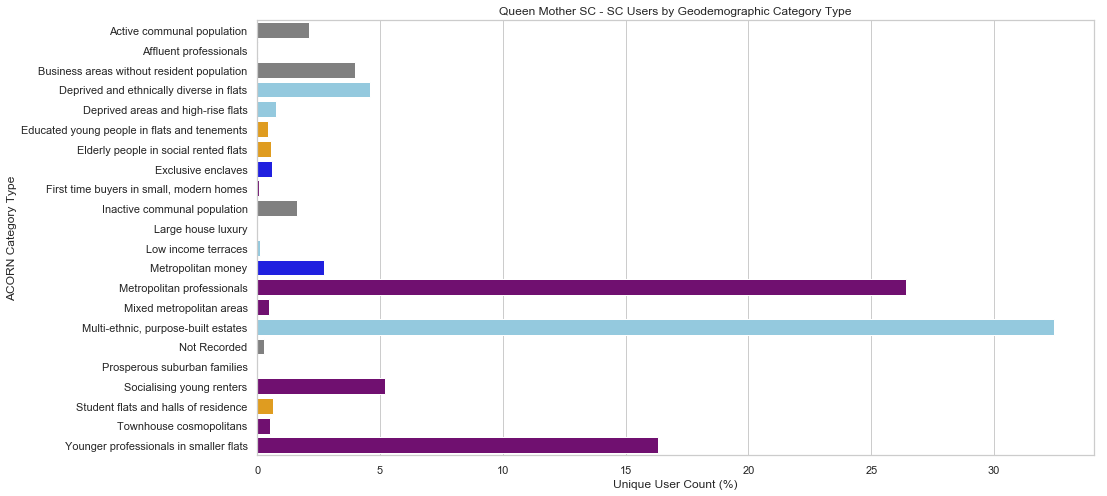

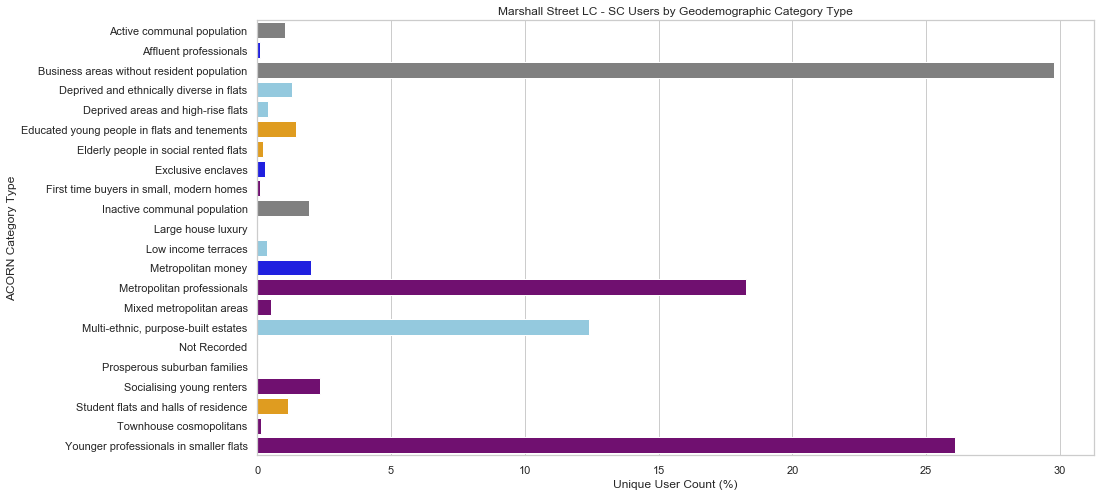

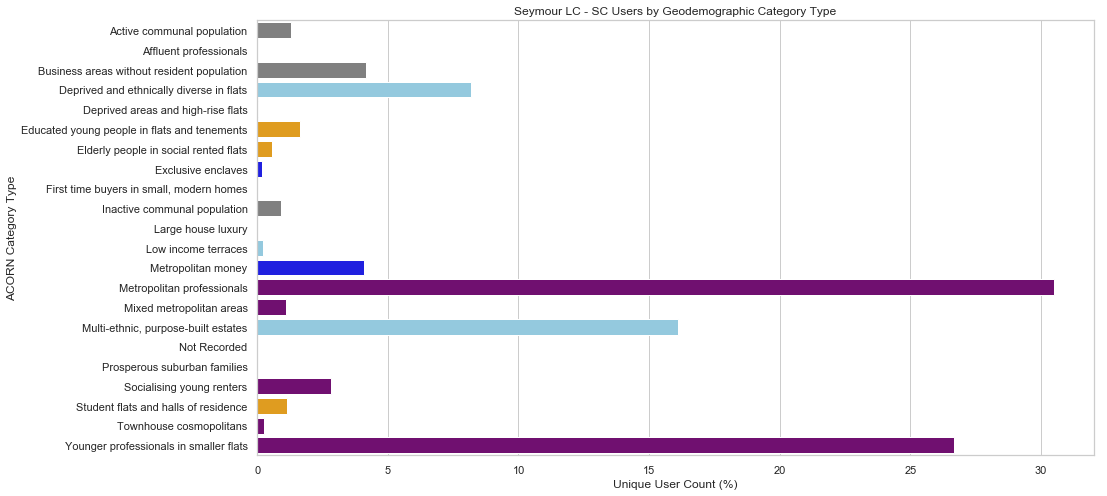

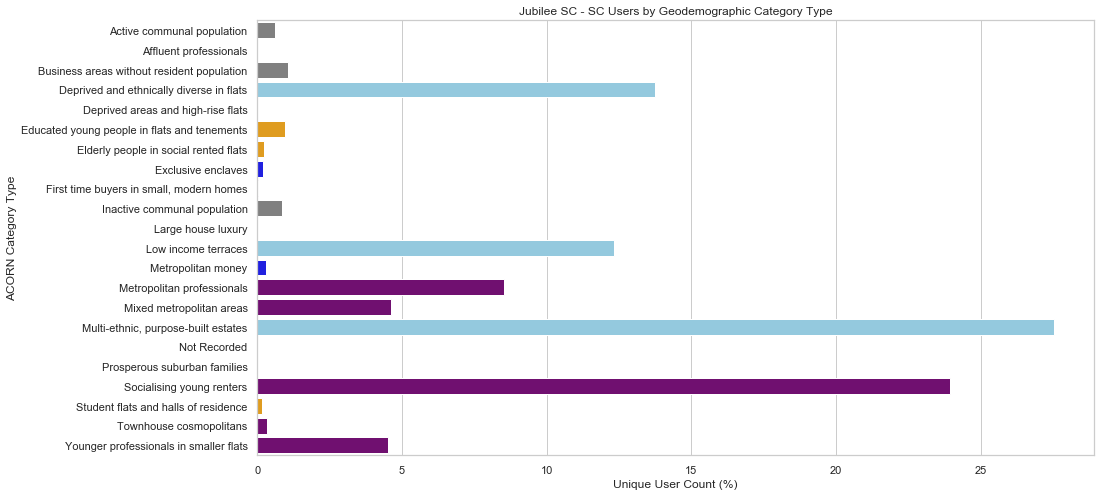

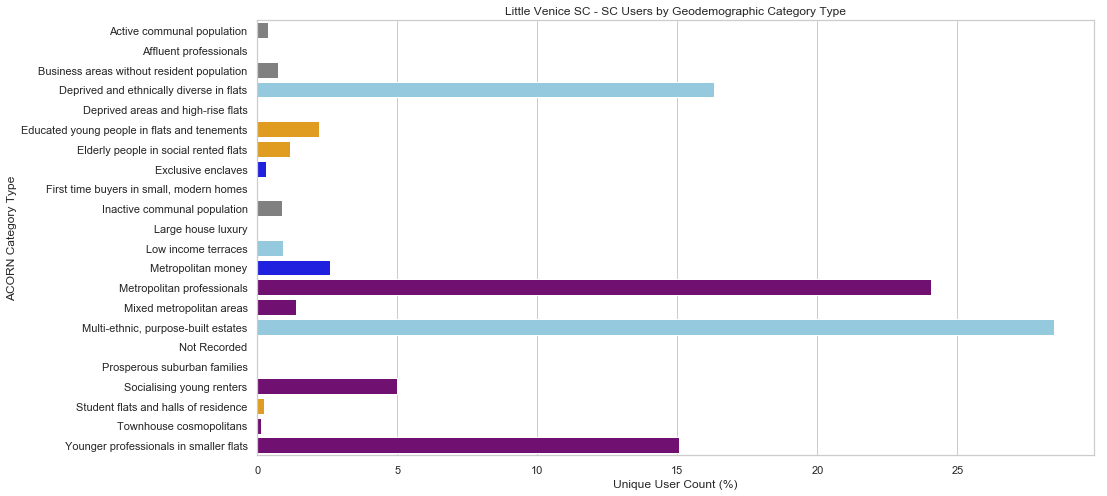

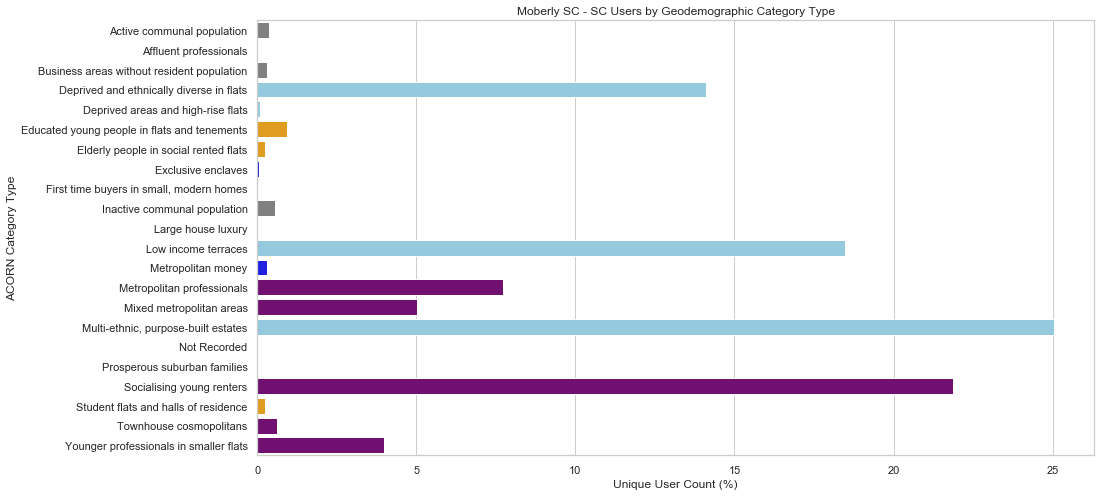

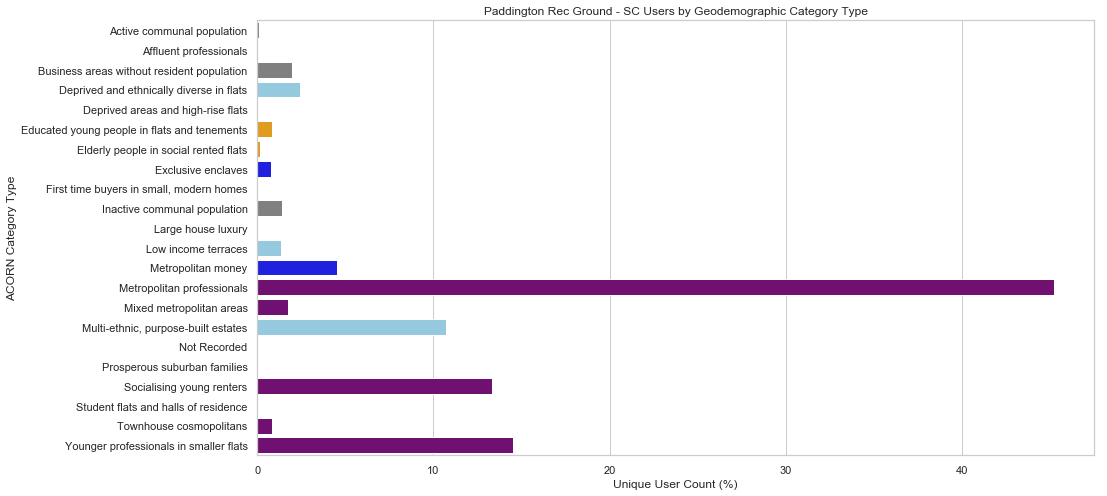

In [14]:
# Plot of users by ACORN category type, by SportsCentre (%)

colors = {'Metropolitan money':'blue', 'Metropolitan professionals':'purple', 'Exclusive enclaves':'blue', 'Student flats and halls of residence':'orange', 'Younger professionals in smaller flats':'Purple', 'Business areas without resident population':'grey', 'Multi-ethnic, purpose-built estates':'skyblue', 'Mixed metropolitan areas':'purple', 
          'Active communal population': 'grey','Socialising young renters':'purple', 'Educated young people in flats and tenements':'orange', 'Inactive communal population': 'grey',
         'Elderly people in social rented flats': 'orange','Deprived and ethnically diverse in flats': 'skyblue','Townhouse cosmopolitans': 'purple','Deprived areas and high-rise flats': 'skyblue','Affluent professionals': 'blue',
         'First time buyers in small, modern homes': 'purple','Not Recorded': 'grey','Low income terraces': 'skyblue', 'Prosperous suburban families': 'blue','Large house luxury': 'blue'}


# Porchester Hall
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_porch, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Porchester Hall - SC Users by Geodemographic Category Type')
plt.show()

# Queen Mother SC
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_qm, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Queen Mother SC - SC Users by Geodemographic Category Type')
plt.show()


# Marshall Street LC
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_marsh, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Marshall Street LC - SC Users by Geodemographic Category Type')
plt.show()


# Seymour LC
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_sey, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Seymour LC - SC Users by Geodemographic Category Type')
plt.show()


# Jubilee SC
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_jub, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Jubilee SC - SC Users by Geodemographic Category Type')
plt.show()


# Little Venice SC
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_lv, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Little Venice SC - SC Users by Geodemographic Category Type')
plt.show()


# Moberly SC
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_mob, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Moberly SC - SC Users by Geodemographic Category Type')
plt.show()


# Paddington Rec Ground
plt.figure(figsize=(15, 8))
ax = sns.barplot(y="CategoryType", x="pct", data=geo_counts_type_pad, ci=None, palette = colors)

ax.set(xlabel="Unique User Count (%)")
ax.set(ylabel="ACORN Category Type")
ax = plt.title('Paddington Rec Ground - SC Users by Geodemographic Category Type')
plt.show()
